In [1]:
!pip install keras_preprocessing
!pip install shap

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.6/42.6 kB 2.1 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 572.6/572.6 kB 10.1 MB/s eta 0:00:00


In [2]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
from keras.models import Model, Sequential
from keras.layers import Dense, Flatten, Conv2D, MaxPooling2D, Input, Conv2DTranspose, BatchNormalization, Dropout, Lambda
import os
from sklearn.model_selection import KFold
from keras_preprocessing.image import load_img
from sklearn import preprocessing

In [3]:
from tensorflow.keras.applications.resnet50 import ResNet50
import tensorflow as tf
from tensorflow.keras.models import load_model
from multiprocessing import Pool
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
from functools import partial
import pathlib
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.callbacks import LearningRateScheduler
from tensorflow import keras
import time
import glob

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [43]:
import shap
import nibabel as nib
from PIL import Image

In [6]:
plt.style.use('dark_background')

First, ***train_images*** and train_labels are initialized as empty lists.

The ***size*** variable is set to the desired size of the images after resizing.

The ***num_processes*** variable is set to the number of CPU cores to use for parallel processing.

A label_map dictionary is defined to map labels to integers.

A ***process_images*** function is defined to preprocess images for a single patient directory. First, a local images list is initialized as an empty list.
Then, the label for the patient directory is determined by mapping the directory name to an integer using the label_map dictionary. Each image file in the patient directory is then processed by reading the image in using OpenCV, resizing it to the desired size, and appending it to the images list. Finally, a tuple containing the images list and the label integer is returned.

***glob.glob*** is used to find all patient directories in the training data directory.

The list of patient directories is passed to ***multiprocessing.Pool.map*** to apply the ***process_images*** function to each directory in parallel, using the specified number of CPU cores. The resulting list of tuples containing preprocessed images and labels for each patient directory is then unpacked into separate ***train_images*** and ***train_labels*** lists.



1.       images = [], This line defines a function named train_process_images that takes one argument case_dir, which is the directory containing the images to be processed.

2.       label = os.path.basename(os.path.dirname(case_dir)), This line extracts the label of the image from its directory name using the os.path.basename and os.path.dirname functions. The os.path.basename function returns the last component of the path (case_dir), while os.path.dirname returns the directory name of a path. The extracted label will be used later to create a label index for the image.



1.       label_idx = label_map[label], This line maps the extracted label to an index using the label_map dictionary, which contains a mapping of label names to their corresponding indexes.

2.       for img_path in glob.glob(os.path.join(case_dir, "*.jpg")):, This line loops over all JPEG images in the directory specified by case_dir using the glob.glob function. The os.path.join function is used to join the directory path with the file extension pattern *.jpg.







In [7]:
#create empty list that will contain train images and its corresponding labels
train_images = [] #Train iamges array
train_labels = [] #Train labels array

In [8]:
#create empty list that will contain test images and its corresponding labels
test_images = [] #Test iamges array
test_labels = [] #Test labels array

In [9]:
size = 224 #The resize of images
num_processes = 4  # Set the number of CPU cores to use
label_map = {"AD": 0, "MCI": 1, "LMCI": 2, "CN": 3}  # Map labels to integers

In [10]:
# This function takes a directory path as input
def train_process_images(case_dir):
    # Initialize an empty list to hold processed images
    images = []
    # Extract the label from the parent directory name and retrieve its corresponding index from the label map
    label = os.path.basename(os.path.dirname(case_dir))
    label_idx = label_map[label]
    # Loop over all .jpg images in the directory and process each one
    for img_path in glob.glob(os.path.join(case_dir, "*.jpg")):
        # Print a message to indicate which image is being processed
        print("Processing image:", img_path)
        # Read the image from the file path and resize it to the specified size
        img = cv2.imread(img_path, cv2.IMREAD_COLOR)
        img = cv2.resize(img, (size, size))
        # Append the processed image to the list of images for this case
        images.append(img)
    # Return the list of processed images and their associated label index
    return images, label_idx



*   pool = Pool(processes=num_processes), This line creates a Pool object with the number of processes specified by num_processes. The Pool object



is used to parallelize the processing of the images, which can speed up the process significantly.

*   results = pool.map(train_process_images, glob.glob("/content/drive/MyDrive/output_images_preprocessed/train/*/*")), This line uses the map method of the Pool object to apply the train_process_images function to each image in the training directory. The glob.glob function is used to find all JPEG images in the training directory. The map method returns a list of tuples, where each tuple contains the processed images and their corresponding label index.



*   pool.close(), pool.join(),These two lines close the Pool object and wait for all the processes to finish before proceeding.

*   for images, label_idx in results:, train_images.extend(images, train_labels.extend([label_idx] * len(images)), This loop iterates over the list of tuples returned by the map method and extracts the processed images and their corresponding label indexes. The loop then extends the train_images and train_labels lists with the extracted images and their label indexes, respectively.





*   train_images = np.array(train_images)
train_labels = np.array(train_labels),  These two lines convert the train_images and train_labels lists to numpy arrays using the np.array function. Numpy arrays are a commonly used data structure for deep learning models, and converting the lists to arrays allows for efficient processing of the data.









In [11]:
# Here this is an object created to specify the number of CPU cores that will be used
pool = Pool(processes=num_processes)

""" The pool.map() is responsible for putting the images in a pool that the CPU'S
    will then process on them, so the images are distributed among the avaliable workers
    it takes 2 paramaters  function that will be applied to each element of the iterable
    input and the second parameter is the iteratabel input
    """
results = pool.map(train_process_images, glob.glob("/content/drive/MyDrive/output_images_preprocessed/train/*/*"))

pool.close()

#This will block the main program until all the worker processes have completed their tasks
pool.join()

for images, label_idx in results:

   # The images that is iterated on is then added to the empty list called train_images
    train_images.extend(images)
    """
    So, the expression [label_idx] * len(images) creates a new list that contains
    len(images) copies of the label_idx. For example, if len(images) equals 3 and
    label_idx equals 1, then the resulting list would be [1, 1, 1].
    This ensures that the train_labels list has the same number of elements as the train_images list,
    and each element in the train_labels
    """
    train_labels.extend([label_idx] * len(images))

train_images = np.array(train_images)
train_labels = np.array(train_labels)

Processing image: /content/drive/MyDrive/output_images_preprocessed/train/AD/ADNI_002_S_4262_MR_Field_Mapping__br_raw_20120420102148554_37_S147985_I299156_brain_folder_0/slice_55.jpg
Processing image: /content/drive/MyDrive/output_images_preprocessed/train/AD/ADNI_002_S_4262_MR_Field_Mapping__br_raw_20121112110201536_169_S174192_I346109_brain_folder_0/slice_52.jpgProcessing image:
 /content/drive/MyDrive/output_images_preprocessed/train/AD/ADNI_002_S_4213_MR_Field_Mapping__br_raw_20120319115059894_105_S144142_I290929_brain_folder_0/slice_54.jpg
Processing image: /content/drive/MyDrive/output_images_preprocessed/train/AD/ADNI_002_S_1280_MR_Field_Mapping__br_raw_20190308112331772_48_S804653_I1140414_brain_folder_0/slice_29.jpg
Processing image: /content/drive/MyDrive/output_images_preprocessed/train/AD/ADNI_002_S_4262_MR_Field_Mapping__br_raw_20120420102148554_37_S147985_I299156_brain_folder_0/slice_51.jpg
Processing image: /content/drive/MyDrive/output_images_preprocessed/train/AD/ADNI_

In [12]:
def test_process_images(case_dir):
    images = []
    label = os.path.basename(os.path.dirname(case_dir))
    label_idx = label_map[label]
    for img_path in glob.glob(os.path.join(case_dir, "*.jpg")):
        print("Processing image:", img_path)
        img = cv2.imread(img_path, cv2.IMREAD_COLOR)
        img = cv2.resize(img, (size, size))
        images.append(img)
    return images, label_idx

In [13]:
pool = Pool(processes=num_processes)
results = pool.map(test_process_images, glob.glob("/content/drive/MyDrive/output_images_preprocessed/test/*/*"))
pool.close()
pool.join()

for images, label_idx in results:
    test_images.extend(images)
    test_labels.extend([label_idx] * len(images))

test_images = np.array(test_images)
test_labels = np.array(test_labels)

Processing image: /content/drive/MyDrive/output_images_preprocessed/test/AD/ADNI_006_S_4713_MR_Field_Mapping__br_raw_20120813162617198_65_S160649_I323333_brain_folder_0/slice_54.jpg
Processing image: /content/drive/MyDrive/output_images_preprocessed/test/AD/ADNI_002_S_2010_MR_Field_Mapping__br_raw_20150813173212382_107_S268728_I505164_brain_folder_0/slice_49.jpg
Processing image: /content/drive/MyDrive/output_images_preprocessed/test/AD/ADNI_002_S_4213_MR_Field_Mapping__br_raw_20110903091137234_185_S121166_I254580_brain_folder_0/slice_50.jpg
Processing image: /content/drive/MyDrive/output_images_preprocessed/test/AD/ADNI_002_S_2073_MR_Field_Mapping__br_raw_20161003151644489_73_S503308_I780962_brain_folder_0/slice_51.jpg
Processing image: /content/drive/MyDrive/output_images_preprocessed/test/AD/ADNI_002_S_4213_MR_Field_Mapping__br_raw_20110903091137234_185_S121166_I254580_brain_folder_0/slice_47.jpg
Processing image: /content/drive/MyDrive/output_images_preprocessed/test/AD/ADNI_002_S_

In [14]:
def plot_dataset_stats(dataset_path, title):
    labels = os.listdir(dataset_path)
    num_images = []
    colors = []
    cmap = plt.cm.get_cmap('YlOrRd')
    for label in labels:
        label_path = os.path.join(dataset_path, label)
        num_cases = len(os.listdir(label_path))
        num_images.append(num_cases * 10)
        colors.append(cmap((num_cases * 10) / max(num_images)))
    plt.bar(labels, num_images, color=colors)
    plt.title(title)
    plt.xlabel("Label")
    plt.ylabel("Number of Images")
    plt.ylim(0, max(num_images) * 1.1)  # Set y-axis limit to 10% more than the maximum value
    plt.show()

def plot_train_dataset_stats(train_dir):
    plot_dataset_stats(train_dir, "Training Dataset Statistics")

def plot_test_dataset_stats(test_dir):
    plot_dataset_stats(test_dir, "Testing Dataset Statistics")

The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.


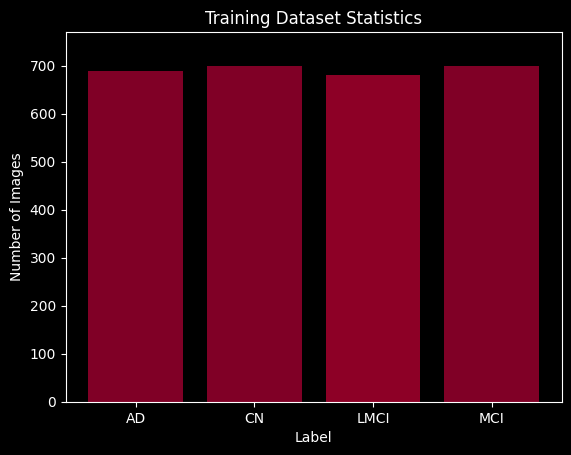

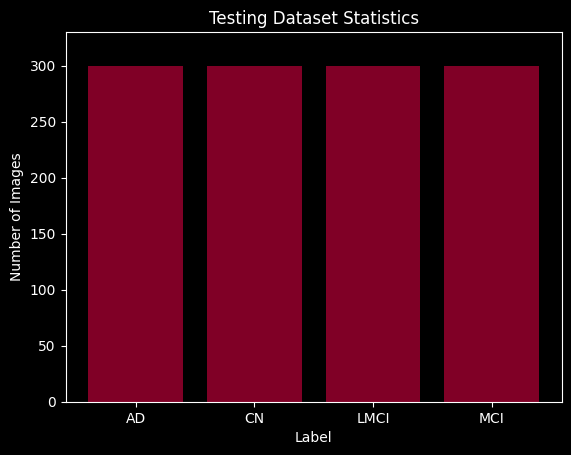

In [15]:
train_dir = '/content/drive/MyDrive/output_images_preprocessed/train'
test_dir = '/content/drive/MyDrive/output_images_preprocessed/test'
plot_train_dataset_stats(train_dir)
plot_test_dataset_stats(test_dir)

In [16]:
class Train_Test_Image_Counter:
    def __init__(self, train_dir, test_dir, label_map):
        self.train_dir = train_dir
        self.test_dir = test_dir
        self.label_map = label_map

    def count_images(self):
        print("Counting images in train directory...")
        self._count_images_helper(self.train_dir)
        print("\nCounting images in test directory...")
        self._count_images_helper(self.test_dir)

    def _count_images_helper(self, data_dir):
        for label in os.listdir(data_dir):
            label_dir = os.path.join(data_dir, label)
            if not os.path.isdir(label_dir):
                continue

            label_idx = self.label_map[label]
            num_images = 0

            for root, dirs, files in os.walk(label_dir):
                for f in files:
                    if f.endswith(".jpg"):
                        num_images += 1

            print(f"Label {label} (index {label_idx}) has {num_images} JPG images.")


In [17]:
counter = Train_Test_Image_Counter("/content/drive/MyDrive/output_images_preprocessed/train", "/content/drive/MyDrive/output_images_preprocessed/test", label_map)
counter.count_images()

Counting images in train directory...
Label AD (index 0) has 690 JPG images.
Label CN (index 3) has 700 JPG images.
Label LMCI (index 2) has 680 JPG images.
Label MCI (index 1) has 700 JPG images.

Counting images in test directory...
Label AD (index 0) has 300 JPG images.
Label CN (index 3) has 300 JPG images.
Label LMCI (index 2) has 300 JPG images.
Label MCI (index 1) has 300 JPG images.


In [18]:
'''
Here we reassingned the variables to new names as they are more meaningful(That is not actual splitting)
The splitting was already done
'''
x_train, y_train, x_test, y_test = train_images, train_labels, test_images, test_labels

In [19]:
class PixelNormalizer:
    def __init__(self, x_train, x_test):
        self.x_train = x_train
        self.x_test = x_test

    def normalize_pixels(self):
        self.x_train = self.x_train / 255.0
        self.x_test = self.x_test / 255.0

In [20]:
class TrainHistory(keras.callbacks.Callback):
    def __init__(self):
        super(TrainHistory, self).__init__()
        self.train_time = []
        self.train_losses = []
        self.train_accs = []

    def on_train_begin(self, logs=None):
        self.start_time = time.time()

    def on_epoch_end(self, epoch, logs=None):
        self.train_time.append(time.time() - self.start_time)
        self.train_losses.append(logs['loss'])
        self.train_accs.append(logs['accuracy'])

        self.plot_training_curves()

    def plot_training_curves(self):
        plt.figure(figsize=(12, 4))
        plt.subplot(1, 2, 1)
        plt.plot(self.train_time, self.train_losses, label='train loss')
        plt.xlabel('Train time (s)')
        plt.ylabel('Loss')
        plt.legend()

        plt.subplot(1, 2, 2)
        plt.plot(range(len(self.train_accs)), self.train_accs, label='train acc')
        plt.xlabel('Epoch')
        plt.ylabel('Accuracy')
        plt.legend()

        plt.show()

In [21]:
# Instantiate the class
normalizer = PixelNormalizer(x_train, x_test)

# Normalize pixels
normalizer.normalize_pixels()

# Access normalized data
x_train = normalizer.x_train
x_test = normalizer.x_test

In [22]:
model = tf.keras.models.load_model('/content/drive/MyDrive/ResNet50_adam_optimizer_final_final_no_mod.h5')

In [23]:
# model=ResNet50(weights="imagenet",include_top=False, input_shape=(size, size, 3))

In [24]:
# """Flatten output layer of Resnet
#   The Flatten() layer is used to convert the tensor into a 1D tensor by flattening it.
#   This means that it takes all the values in the tensor and puts them in a single long vector,
#   while maintaining their order.
#   The benefit of using the Flatten layer is that it simplifies the data and makes it easier for the neural network to process.
#   In many cases, the input data to a neural network is structured in a multi-dimensional format, such as images represented as
#   2D arrays or time series data represented as 3D arrays. However, most neural network architectures expect the input to be a 1D array of values.
#   By using the Flatten layer, we can easily convert the input data to the appropriate format, regardless of its original shape."""

# flattened = tf.keras.layers.Flatten()(model.output)

# #Fully connected layer 1
# fc1 = tf.keras.layers.Dense(128, activation='relu', name="AddedDense1")(flattened)

# #Fully connected layer, output layer
# fc2 = tf.keras.layers.Dense(4, activation='softmax', name="AddedDense2")(fc1)
# model = tf.keras.models.Model(inputs=model.input, outputs=fc2)

In [25]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 112, 112, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                              

In [26]:
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [27]:
# train_history = TrainHistory()

In [28]:
# # Train the model with the combined data
# adam_train = model.fit(
#     x_train, y_train,
#     epochs=10,
#     batch_size=10,
#     callbacks=[train_history]
# )

In [29]:
# model.save('/content/drive/MyDrive/Saved Models/ResNet50_adam_optimizer_final_final.h5')

In [63]:
Test_loss, Test_accuracy = model.evaluate(x_test,  y_test)

38/38 [==============================] - 4s 93ms/step - loss: 1.1158 - accuracy: 0.1817


In [64]:
y_pred = np.argmax(model.predict(x_test), axis=-1)

38/38 [==============================] - 3s 91ms/step


In [65]:
print('Test Accuracy: %.3f' % accuracy_score(y_test, y_pred))

Test Accuracy: 0.907


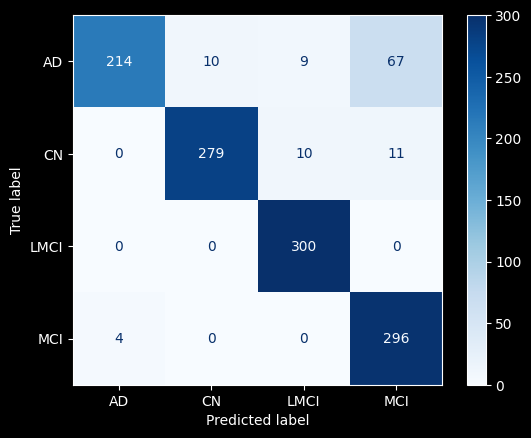

<Figure size 640x480 with 0 Axes>

In [66]:
labels = ["AD", "CN", "LMCI","MCI"]

cm = confusion_matrix(y_test, y_pred)

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)

disp.plot(cmap=plt.cm.Blues)
plt.figure()
plt.show()

Here i test on the cases found in the test directory

In [70]:
# Path to the case folder
case_folder = '/content/drive/MyDrive/output_images_preprocessed/test/CN/ADNI_002_S_0295_MR_Field_Mapping__br_raw_20110602125348004_49_S110473_I238622_brain_folder_0/'

# List to store the predicted labels
predicted_labels = []

# List to store the preprocessed images
preprocessed_images = []

# Iterate over the images in the case folder
for image_file in os.listdir(case_folder):
    if not image_file.endswith('.jpg'):
        continue

    # Load the image
    image_path = os.path.join(case_folder, image_file)
    image = cv2.imread(image_path)

    # Preprocess the image
    image = image.astype('float32') / 255.0
    image = cv2.resize(image, (224, 224))

    # Append the preprocessed image to the list
    preprocessed_images.append(image)

    # Reshape the preprocessed image to match the model's input shape
    preprocessed_image = np.reshape(image, (1, 224, 224, 3))

    # Make predictions using the preprocessed image
    predictions = model.predict(preprocessed_image)

    # Get the predicted label
    predicted_label = np.argmax(predictions[0])
    predicted_labels.append(predicted_label)

# Convert the preprocessed images list to a numpy array
preprocessed_images = np.array(preprocessed_images)

# Get the actual label from the case folder path
actual_label = label_map[os.path.basename(os.path.dirname(os.path.dirname(case_folder)))]

# Print the case result
print("Case: ", case_folder)
print("Actual label: ", actual_label)
print("Predicted labels: ", predicted_labels)
print()

1/1 [==============================] - 0s 21ms/step
Case:  /content/drive/MyDrive/output_images_preprocessed/test/CN/ADNI_002_S_0295_MR_Field_Mapping__br_raw_20110602125348004_49_S110473_I238622_brain_folder_0/
Actual label:  1
Predicted labels:  [3, 3, 3, 3, 3, 3, 3, 3, 3, 3]



`tf.keras.backend.set_learning_phase` is deprecated and will be removed after 2020-10-11. To update it, simply pass a True/False value to the `training` argument of the `__call__` method of your layer or model.


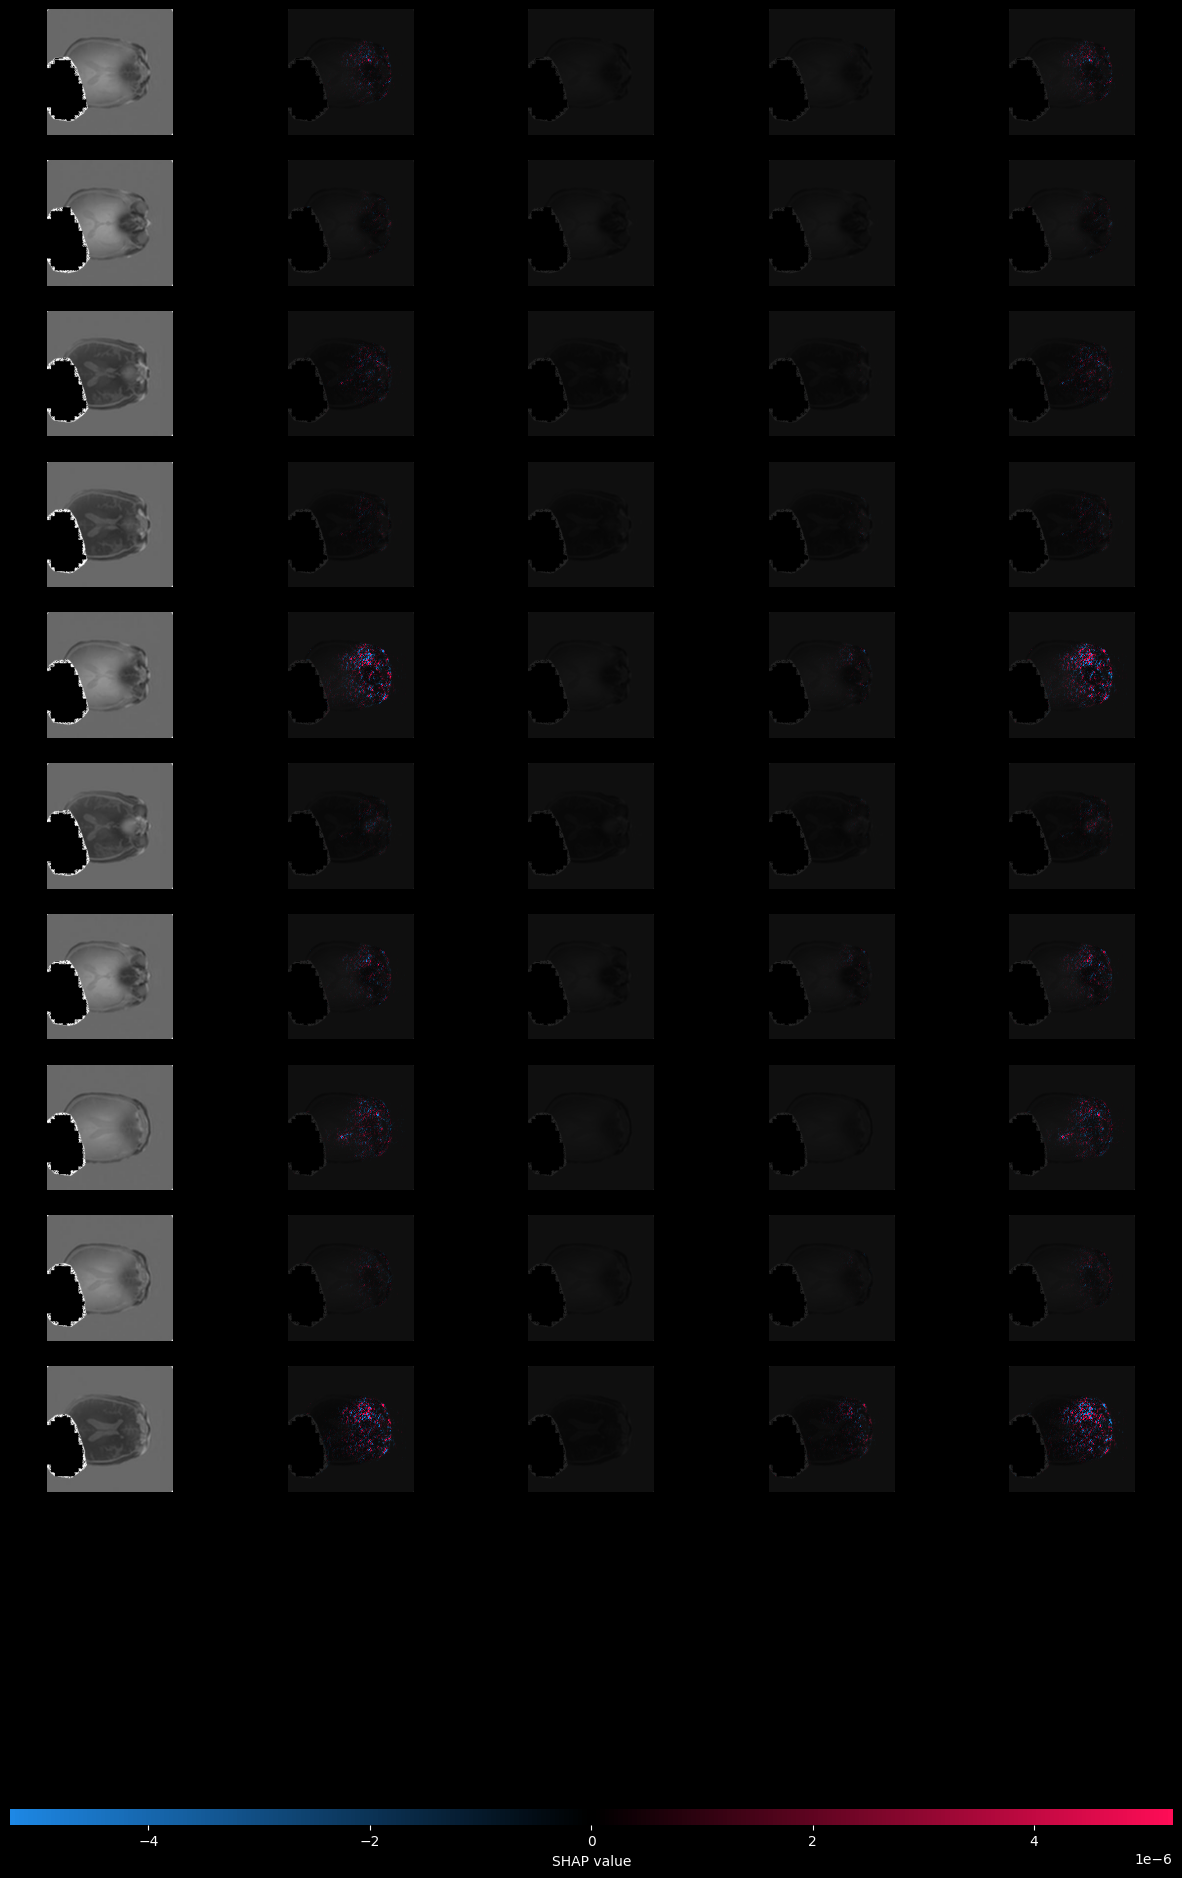

In [35]:
explainer = shap.GradientExplainer(model, preprocessed_images)

# Calculate SHAP values for the preprocessed images
shap_values = explainer.shap_values(preprocessed_images)

# Rescale the preprocessed images to [0, 255]
preprocessed_images_scaled = (preprocessed_images * 255).astype(np.uint8)

# Visualize the SHAP values
shap.image_plot(shap_values, -preprocessed_images_scaled)

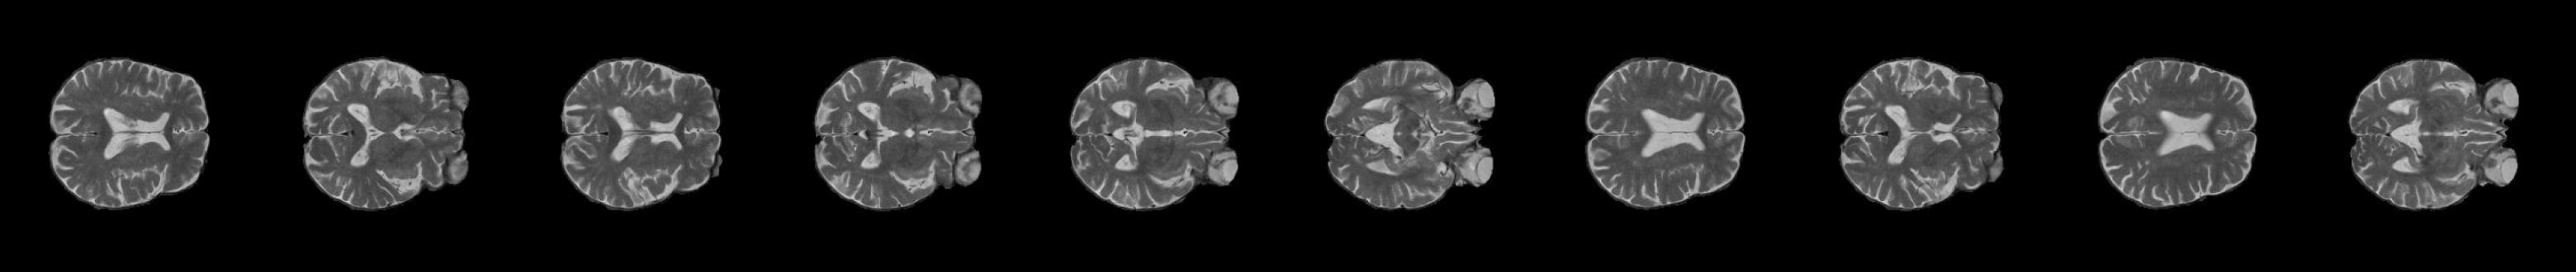

In [36]:
# Stack the images vertically
stacked_image = np.hstack(images)

# Display the stacked image with larger figure size
plt.figure(figsize=(40, 40))
plt.imshow(cv2.cvtColor(stacked_image, cv2.COLOR_BGR2RGB))
plt.axis('off')
plt.show()

# MRI Slicing class part

In [37]:
Anonyoums_AD_sample_1 = '/content/drive/MyDrive/AD'

In [46]:
class ImageSlicer:
    def __init__(self, dataset_path):
        # Set the path to the dataset
        self.dataset_path = dataset_path
        # Define the labels for the dataset
        self.labels = ['AD', 'CN', 'LMCI', 'MCI']
        # Set the path to the output folder for the sliced images
        self.output_folder = '/content/drive/MyDrive/output_images_preprocessed_anon'
        # Set the range of slices to extract from each image
        self.slices_range = range(10)

    def slice_images(self, filename):
        # Set the input folder path for the label
        input_folder = os.path.join(self.dataset_path, 'AD')
        # Set the output folder path for the label
        output_folder = os.path.join(self.output_folder, 'AD')
        # Create the output folder if it doesn't exist
        os.makedirs(output_folder, exist_ok=True)

        # Set the input file path
        filepath = os.path.join(input_folder, filename)
        # Load the NIfTI image using the nibabel library
        nii_image = nib.load(filepath)
        # Convert the image to a NumPy array and add an additional dimension along axis=-1
        np_image = np.array(nii_image.get_fdata())[..., np.newaxis]
        # Remove the additional dimension along axis=-1
        np_image = np.squeeze(np_image, axis=-1)
        # Cast the NumPy array to the float32 data type
        np_image = np_image.astype(np.float32)
        # Normalize the image to the range [0, 255]
        min_val = np.min(np_image)
        max_val = np.max(np_image)
        np_image = ((np_image - min_val) * (255 / (max_val - min_val))).astype(np.uint8)
        # Get the number of slices in the image 3D
        num_slices = np_image.shape[2]
        # Get the middle slice index
        middle_slice = num_slices // 2
        # Get the starting and ending slice indices
        start_slice = max(0, middle_slice - 5)
        end_slice = min(num_slices - 1, middle_slice + 4)
        # Create a folder for the image slices
        folder_name = os.path.splitext(filename)[0] + '_folder_0'
        folder_path = os.path.join(output_folder, folder_name)
        os.makedirs(folder_path, exist_ok=True)
        # Extract and save each slice within the specified range
        for i in range(start_slice, end_slice+1):
            # Extract the slice as a PIL Image object
            slice_image = Image.fromarray(np_image[:, :, i])
            # Convert the slice to the RGB color mode
            slice_image = slice_image.convert('RGB')
            # Set the filename for the slice image
            slice_filename = f'slice_{i}.jpg'
            # Set the filepath for the slice image
            slice_filepath = os.path.join(folder_path, slice_filename)
            # Save the slice image as a JPEG file
            slice_image.save(slice_filepath)


In [47]:
slicer = ImageSlicer('/content/drive/MyDrive/output_images_preprocessed_anon')
slicer.slice_images('/content/drive/MyDrive/AD/ADNI_136_S_0426_MR_MPR____N3__Scaled_Br_20081013164839346_S51029_I120441.nii')

In [49]:
slicer = ImageSlicer('/content/drive/MyDrive/output_images_preprocessed_anon')
slicer.slice_images('/content/drive/MyDrive/CN/ADNI_126_S_0605_MR_MPR__GradWarp__B1_Correction__N3__Scaled_Br_20081014091433142_S52648_I120562.nii')

# Classification Process

In [50]:
# Path to the case folder
case_folder = '/content/drive/MyDrive/CN/ADNI_126_S_0605_MR_MPR__GradWarp__B1_Correction__N3__Scaled_Br_20081014091433142_S52648_I120562_folder_0/'

# List to store the predicted labels
predicted_labels = []

# List to store the preprocessed images
preprocessed_images = []

# Iterate over the images in the case folder
for image_file in os.listdir(case_folder):
    if not image_file.endswith('.jpg'):
        continue

    # Load the image
    image_path = os.path.join(case_folder, image_file)
    image = cv2.imread(image_path)

    # Preprocess the image
    image = image.astype('float32') / 255.0
    image = cv2.resize(image, (224, 224))

    # Append the preprocessed image to the list
    preprocessed_images.append(image)

    # Reshape the preprocessed image to match the model's input shape
    preprocessed_image = np.reshape(image, (1, 224, 224, 3))

    # Make predictions using the preprocessed image
    predictions = model.predict(preprocessed_image)

    # Get the predicted label
    predicted_label = np.argmax(predictions[0])
    predicted_labels.append(predicted_label)

# Convert the preprocessed images list to a numpy array
preprocessed_images = np.array(preprocessed_images)

# Get the actual label from the case folder path
actual_label = label_map[os.path.basename(os.path.dirname(os.path.dirname(case_folder)))]

# Print the case result
print("Case: ", case_folder)
print("Actual label: ", actual_label)
print("Predicted labels: ", predicted_labels)
print()

1/1 [==============================] - 0s 21ms/step
Case:  /content/drive/MyDrive/CN/ADNI_126_S_0605_MR_MPR__GradWarp__B1_Correction__N3__Scaled_Br_20081014091433142_S52648_I120562_folder_0/
Actual label:  3
Predicted labels:  [2, 2, 2, 2, 2, 2, 2, 2, 2, 2]

